In [1]:
%matplotlib ipympl
import numpy as np
import sys

# setting path for mask_utils package
sys.path.append('..')

from mask_utils.code_utils import next_prime, ura_mura
from mask_utils.imaging_utils import  decode, decode_var, generate_bulk, get_openfraction,  get_skysign, get_skycoords, get_detimage_edges, get_detimage
from mask_utils.fits_utils import read_mask_bulk, write_mask_fits, read_fits_events
from mask_utils.image_utils import upscale#, fshift, ferosion
from scipy.ndimage import center_of_mass
from scipy.ndimage import shift as ndshift

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
mask_file = "F:/CodedMasks/mask_050_1040x17/mask_050_1040x17_20250725.fits"

In [3]:
mask, hdmask = read_mask_bulk(mask_file, 2, header_out=True, verbose=False)
rmatrix = read_mask_bulk(mask_file, 3, verbose=False)
bulk = read_mask_bulk(mask_file, 4, verbose=False)

In [4]:
#Removing fractional bulk elements to simplify the analysis
bulk[bulk < 1] = 0

In [5]:
#Gets mask information and define X, Y vectors (centers and edges)
ELXDIM = hdmask['ELXDIM'] 
ELYDIM = hdmask['ELYDIM'] 
ELXN   = hdmask['ELXN'] 
ELYN   = hdmask['ELYN']
MTHICK = 0.150
focal  = 202.9


In [6]:
#Upscaling mask, rmatrix, bulk
up_f_x, up_f_y = 10.0, 2.0

mask = upscale(mask, up_f_y, up_f_x)
rmatrix = upscale(rmatrix, up_f_y, up_f_x)
bulk = upscale(bulk, up_f_y, up_f_x)

ELXDIM /= up_f_x
ELYDIM /= up_f_y
ELXN   *= up_f_x
ELYN   *= up_f_y

In [7]:
def fshift(arr, lagx, lagy):
    """
    Shifts a 2D array (casted to float) with fractional shifts using SciPy.
    
    Note: SciPy's shift convention is (y, x), but our images are already in the right shape
    """
    return ndshift(arr, (lagx, lagy), 'float', order=1, prefilter=True, mode='grid-constant', cval=0.0)

In [8]:
def ferosion(arr, step, cut):
    # number of bins to cut
    ncuts = int(cut / step)
    #print('ncuts:', ncuts)
    cutted = arr *        fshift(arr, ncuts, 0) if ncuts else arr

    # array indexes to be fractionally reduced:
    #   - the bin with the decimal values is the one
    #     to the left or right wrt the cutted bins
    erosion_value = abs(cut / step - ncuts)
    #print('erosion_value', erosion_value)
    border = (cutted - fshift(cutted, int(np.sign(cut)), 0 )) > 0
    return cutted -border * erosion_value

In [9]:
def gen_detimage(mask, xshift, yshift, bulk):
    detimage = fshift(mask, xshift, yshift) * bulk
    return detimage

In [10]:
def apply_vignetting(detimage, xshift, yshift, focal, ELXDIM, ELYDIM, MTHICK):
    angle_x_rad = -np.arctan(xshift*ELXDIM / focal) #note the -1
    red_factor_x = MTHICK * np.tan(angle_x_rad)
    sg1 = ferosion(detimage,  ELXDIM, red_factor_x)

    angle_y_rad = -np.arctan(yshift*ELYDIM / focal) #note the -1
    red_factor_y = MTHICK * np.tan(angle_y_rad)
    sg2 = ferosion(detimage.T, ELYDIM, red_factor_y)
    
    return sg1 * sg2.T

In [11]:
#filein = "C:/Users/Utente/Desktop/galctr_rxte-sax_mask_050_1040x17_opaquemask_infdet_2-50keV_1ks_cam1a_detected.fits"
filein ="C:/Users/Utente/Desktop/galctr_rxte-sax_mask_050_1040x17_opaquemask_infdet_2-50keV_1ks_cam1b_detected.fits"

In [12]:
det, hdet0, hdet1 = read_fits_events(filein, header0=True, header1=True, verbose=False)
xedges, yedges = get_detimage_edges(ELXDIM, ELYDIM, ELXN, ELYN)
#Computes detector image
detimagesim = get_detimage(det, xedges, yedges) * bulk

In [13]:
skysim = decode(detimagesim, rmatrix, bulk)

peak = np.max(skysim)
peak_p = np.unravel_index(np.argmax(skysim), skysim.shape)
print(peak_p)

(np.int64(13519), np.int64(867))


In [14]:
xspan = int(0.25/ELXDIM)
yspan = int(15.5/ELYDIM)
com = center_of_mass(skysim[peak_p[0] - xspan:peak_p[0] + xspan - 1 , peak_p[1]-yspan: peak_p[1]+yspan -1])
print("Peak Center Of Mass:", peak_p[0] - xspan + com[0], peak_p[1] - yspan + com[1])

Peak Center Of Mass: 13519.46335866059 867.9529569411258


In [15]:

xspan = int(0.25/ELXDIM)
yspan = int(15.5/ELYDIM)

labels = np.zeros(skysim.shape)
labels[peak_p[0] - xspan:peak_p[0] + xspan - 1 , peak_p[1]-yspan: peak_p[1]+yspan -1] = 1

com = center_of_mass(skysim, labels=labels, index=1)
cx, cy = (skysim.shape[0] - 1 ) // 2, (skysim.shape[1] - 1 ) // 2

shiftX, shiftY = cx - com[0] - 1.40, cy - com[1] + 0.55
print("ShiftX:", shiftX)#np.rad2deg(np.arctan(shiftX*ELXDIM/focal)))
print("ShiftY:", shiftY)#np.rad2deg(np.arctan(shiftY*ELYDIM/focal)))


ShiftX: -3121.8633586605906
ShiftY: 175.59704305887436


In [16]:
focal = 202.9 + 0.150

detimage_iros = mask
detimage_iros = apply_vignetting(detimage_iros, shiftX, shiftY, focal, ELXDIM, ELYDIM, MTHICK)
detimage_iros = gen_detimage(detimage_iros, shiftX, shiftY, bulk)

skyiros = decode(detimage_iros, rmatrix, bulk) 
skyiros = skyiros / np.max(skyiros) * np.max(skysim)

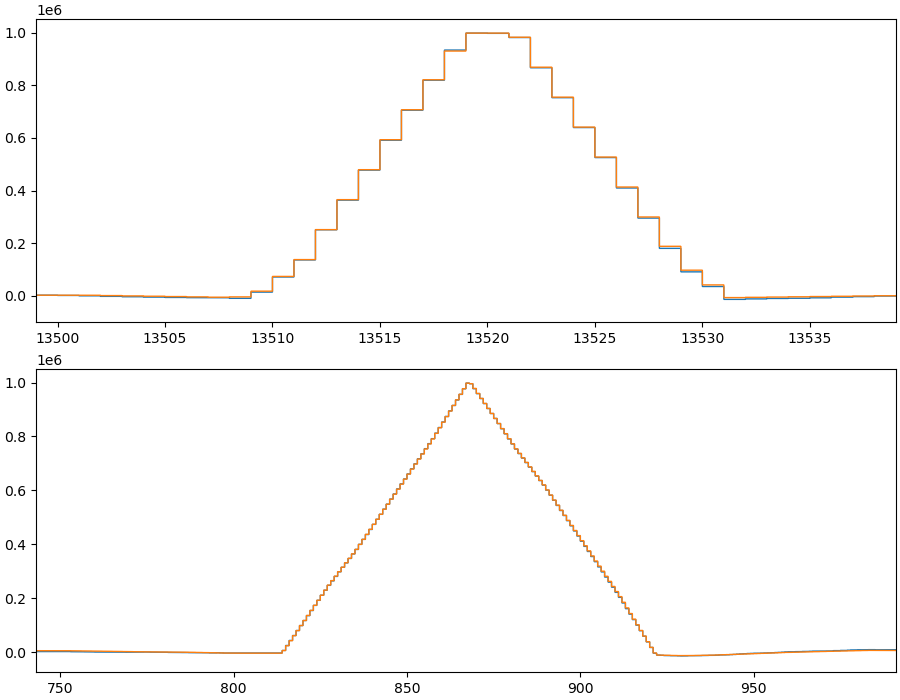

In [17]:
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(9, 7))
axs[0].set_title('')
axs[0].stairs(skysim[:, peak_p[1]])
axs[0].stairs(skyiros[:, peak_p[1]])

axs[0].set_xlim( (peak_p[0] - 2*xspan , peak_p[0] + 2*xspan))

axs[1].set_title('')
axs[1].stairs(skysim[peak_p[0], :])
axs[1].stairs(skyiros[peak_p[0], :])

axs[1].set_xlim( (peak_p[1] - 2*yspan , peak_p[1] + 2*yspan))

plt.show()

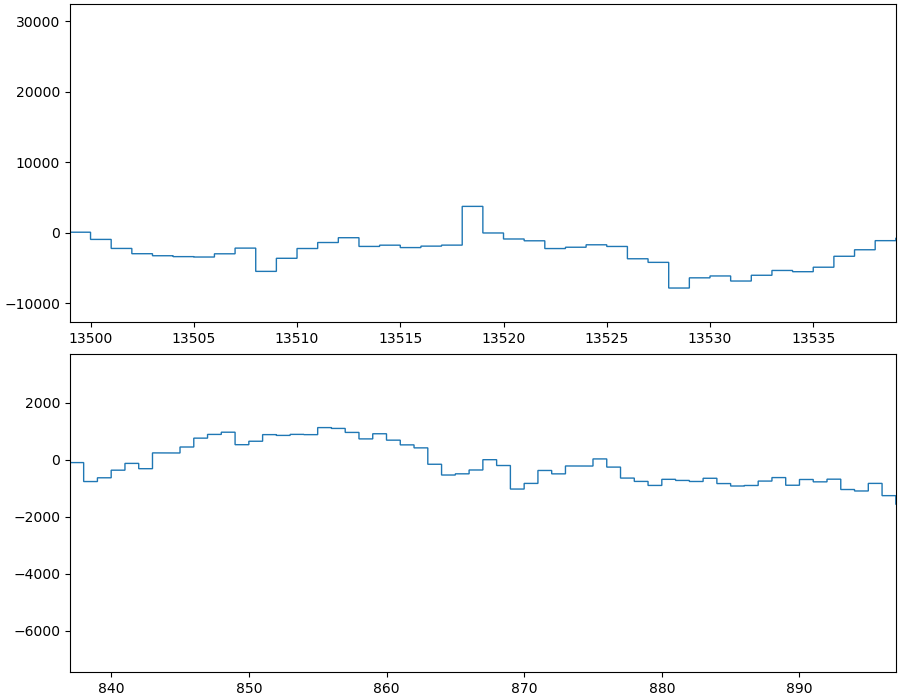

In [18]:
skydiff = skysim - skyiros

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(9, 7))
axs[0].set_title('')
axs[0].stairs(skydiff[:, peak_p[1]])

axs[0].set_xlim( (peak_p[0] - 20 , peak_p[0] + 20))

axs[1].set_title('')
axs[1].stairs(skydiff[peak_p[0], :])

axs[1].set_xlim( (peak_p[1] - 30 , peak_p[1] + 30))

plt.show()

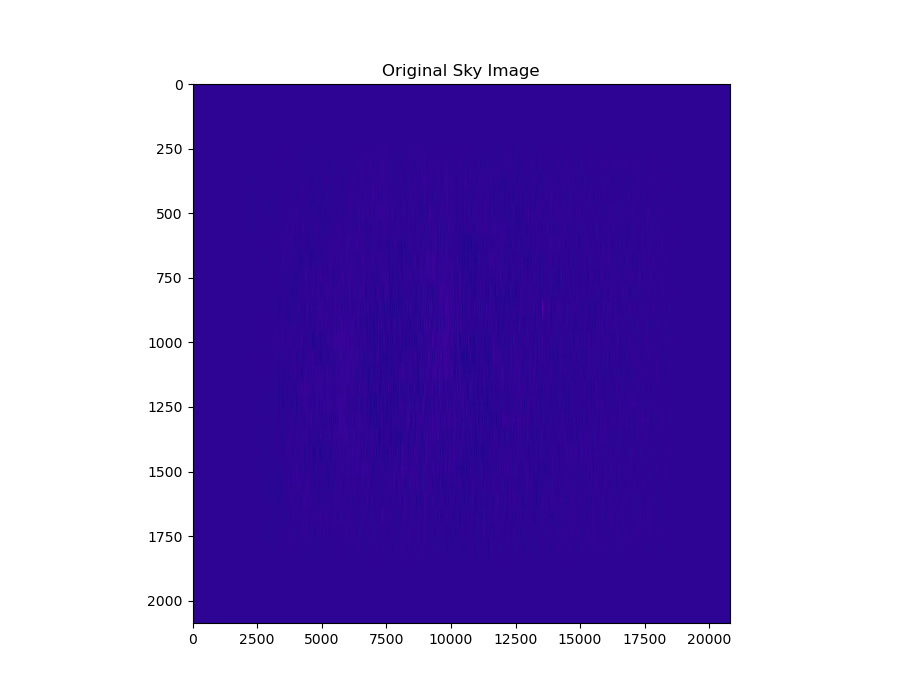

In [19]:
plt.figure(figsize=(9, 7))
plt.title("Original Sky Image")
plt.imshow(skysim.T, cmap=cm.plasma,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

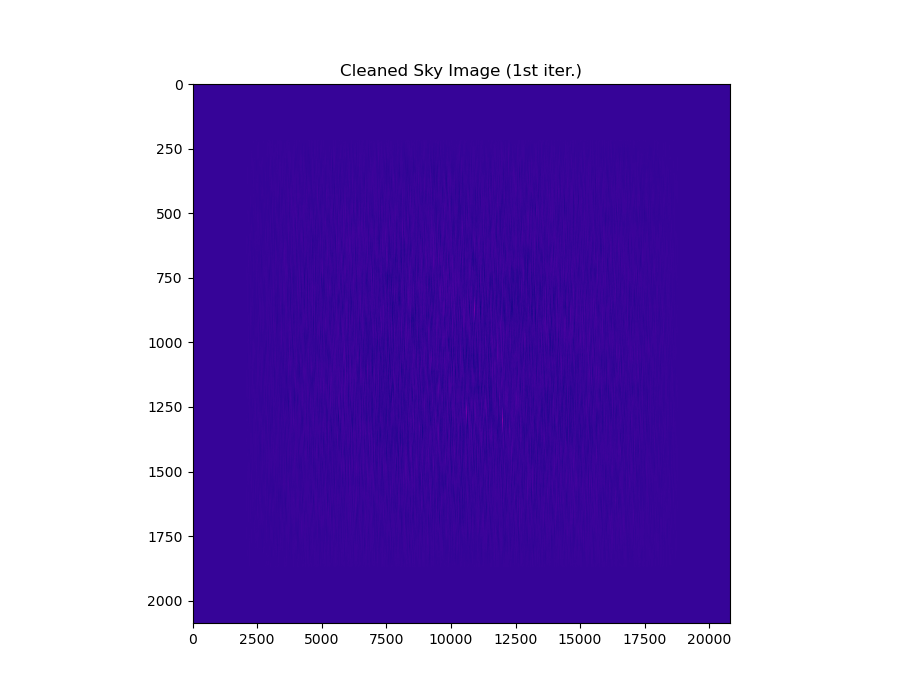

In [20]:
plt.figure(figsize=(9, 7))
plt.title("Cleaned Sky Image (1st iter.)")
plt.imshow(skydiff.T, cmap=cm.plasma,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

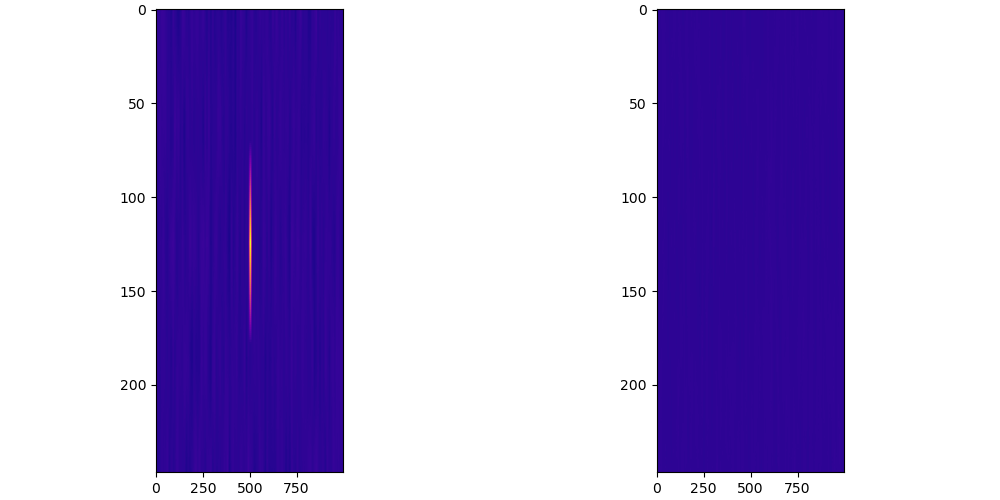

In [21]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
#axs[0].set_title('Fine Direction')
vmin, vmax = np.min(skysim),np.max(skysim)

axs[0].imshow(skysim[peak_p[0] - 50*xspan:peak_p[0] + 50*xspan - 1 , peak_p[1]-2*yspan: peak_p[1]+2*yspan -1].T, cmap=cm.plasma, vmin=vmin, vmax=vmax, interpolation='nearest', aspect=ELYDIM/ELXDIM)
axs[1].imshow(skydiff[peak_p[0] - 50*xspan:peak_p[0] + 50*xspan - 1 , peak_p[1]-2*yspan: peak_p[1]+2*yspan -1].T, cmap=cm.plasma, vmin=vmin, vmax=vmax, interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()